# Building a timeline with patch notes

inspired from matplotlib's timeline example
https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/timeline.html

patches release data is drawn from
https://hearthstone.gamepedia.com/Patches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.style.use("seaborn")
sns.set(style="ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Definitions

In [3]:
DATE_FORMAT = "%d-%m-%Y"
standard_years_df = pd.read_csv("data/standard_years.csv", index_col=2)
df = standard_years_df
df.start = pd.to_datetime(df.start, format=DATE_FORMAT)
df.end = pd.to_datetime(df.end, format=DATE_FORMAT)
df.end = df.end.fillna(pd.to_datetime("today"))

def annotate_standard_years(ax, ytitle, color=None, xlim=None):
    if color is None:
        color = "orange"
    df = standard_years_df
    def _title_parse(name):
        if "year" in name.lower():
            return name
        else:
            return f"Year of the\n{name}"
    df["titles"] = [_title_parse(name) for name in df.index]
    for irow, (name, (d1, d2, title)) in enumerate(df.iterrows()):
        if xlim is not None:
            if d2 < xlim[0]:
                continue
            if d1 < xlim[0]:
                d1 = xlim[0]
        ax.text(d1 + (d2-d1)/10, ytitle, title, zorder=10)
        ax.axvspan(d1, d2, alpha=0.1+0.3*(irow%2), color=color, zorder=-1)

def annotate_patches(ax, kind, levels, linefmt, markerfmt=None):
    patches_df = pd.read_csv("data/patches_data.csv", index_col=0)
    df = patches_df.query(f"kind == '{kind}'")
    df.index = pd.to_datetime(df.index, format=DATE_FORMAT)
    df = df.sort_values(by="date")

    lvls = np.tile(levels, int(np.ceil(len(df.index)/len(levels))))[:len(df.index)]

    markerline, stemline, baseline = ax.stem(df.index, lvls,
                                             basefmt="k-",
                                             linefmt=linefmt,
                                             markerfmt=markerfmt,
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros_like(df.index, dtype=int))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(lvls > 0).astype(int)]

    for d, l, r, va in zip(df.index, lvls, df.description, vert):
        ax.annotate(r, xy=(d, l), va=va, ha="center")

# Script

''

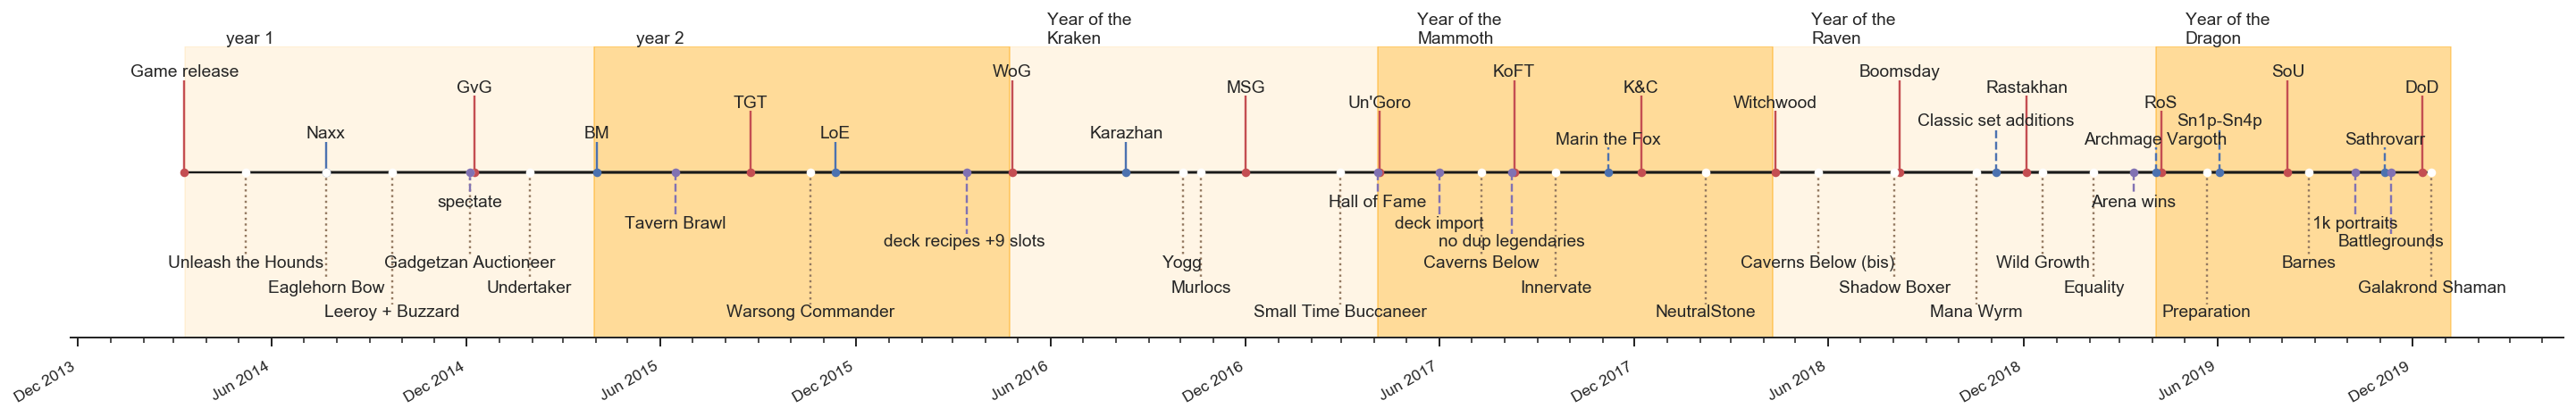

In [10]:
# figure preping
fig, ax = plt.subplots(figsize=(25, 3))
sns.set_context("paper")

# remove axes and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.15)


# data plotting
annotate_standard_years(ax, ytitle=2.1)
annotate_patches(ax, kind="expansion", levels=[1.5, 1.25, 1], linefmt="C3-", markerfmt="C3o")
annotate_patches(ax, kind="adventure", levels=[0.5], linefmt="C0-")
annotate_patches(ax, kind="batch", levels=[0.4, 0.7], linefmt="C0--")
annotate_patches(ax, kind="nerfs", levels=[-1.35, -1.75, -2.15], linefmt="C5:", markerfmt="wo")
annotate_patches(ax, kind="feature", levels=[-0.35, -0.7, -1], linefmt="C4--", markerfmt="C4o")


# ticks formatting
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax.get_xaxis().set_minor_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
,

## legends
- red line: expansion release
- blue line: adventure release
- blue dashed-line: out-of-cycle single-card release
- purple dashed-line: feature release
- brown dottend-line: nerf patch. Often, more than one card is affected, but I only show one nemorable offender for each nerf patch.

The distinction Standard/Wild appeared with Whispers from the old Gods (WoG). The first two years were not named, but are however distinct in that their contents was not send to Wild-only at the same point.
I consider here the release of an expansion _patch_ to be the marker of a new year, rather than the expansion release itself (usually 2 days to a week later), which is why Rise of Shadows (Ros) appears a bit later than the corresponding Year of the Dragon.